In [13]:

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoFoldersDataset, MontevideoFoldersDataset_w_time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

import numpy as np
import random
import time
from src.dl_models.phydnet import ConvLSTM,PhyCell, EncoderRNN
#from data.moving_mnist import MovingMNIST
from src.dl_models.phydnet import K2M
from skimage.measure import compare_ssim as ssim
import argparse
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
# root = 'data/'
# batch_size = 16

# mm = MovingMNIST(root=root, is_train=True, n_frames_input=10, n_frames_output=10, num_objects=[2])
# train_loader = torch.utils.data.DataLoader(dataset=mm, batch_size=batch_size, shuffle=True, num_workers=0)

# mm = MovingMNIST(root=root, is_train=False, n_frames_input=10, n_frames_output=10, num_objects=[2])
# test_loader = torch.utils.data.DataLoader(dataset=mm, batch_size=batch_size, shuffle=False, num_workers=0)

PATH_DATA = 'data/mvd/validation/'

normalize = preprocessing.normalize_pixels(mean0=False)
val_mvd = MontevideoFoldersDataset(
                                    path=PATH_DATA,
                                    in_channel=3,
                                    out_channel=1,
                                    min_time_diff=5,
                                    max_time_diff=15,
                                    csv_path=None,
                                    transform=normalize
                                    )

val_loader = DataLoader(val_mvd, batch_size=1, shuffle=False)

3
tensor([7579, 7726, 1661,   86, 7563, 2544, 9218, 4554, 2679, 6261, 4644, 3379,
        8432, 2943, 2704, 2656])
torch.Size([16, 10, 1, 64, 64])
torch.Size([16, 10, 1, 64, 64])


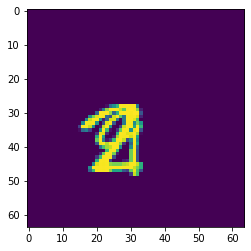

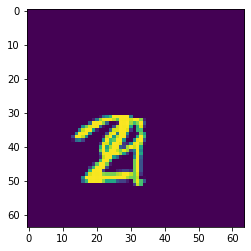

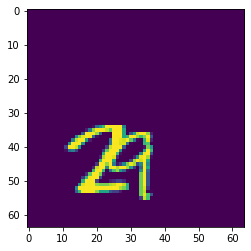

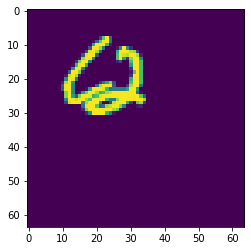

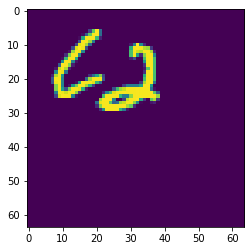

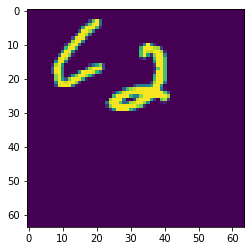

In [25]:

for i, out in enumerate(train_loader, 0):
    print(len(out))
    print(out[0])
    input_tensor = out[1].to(device)
    target_tensor = out[2].to(device)
    print(input_tensor.shape)
    print(target_tensor.shape)
    break

plt.imshow(input_tensor[0,0,0])
plt.show()
plt.imshow(input_tensor[0,1,0])
plt.show()
plt.imshow(input_tensor[0,2,0])
plt.show()

plt.imshow(input_tensor[1,0,0])
plt.show()
plt.imshow(input_tensor[1,1,0])
plt.show()
plt.imshow(input_tensor[1,2,0])
plt.show()


In [3]:
constraints = torch.zeros((49,7,7)).to(device)
ind = 0
for i in range(0,7):
    for j in range(0,7):
        constraints[ind,i,j] = 1
        ind +=1    
        
#print(constraints)

In [56]:
def train_on_batch(input_tensor, target_tensor, encoder, encoder_optimizer, criterion, teacher_forcing_ratio):                
    encoder_optimizer.zero_grad()
    # input_tensor : torch.Size([batch_size, input_length, channels, cols, rows])
    input_length  = input_tensor.size(1)
    target_length = target_tensor.size(1)
    
    loss = 0
    for ei in range(input_length-1): 
        encoder_output, encoder_hidden, output_image, _, _ = encoder(input=input_tensor[:, ei, :,:, :],
                                                                     first_timestep=(ei==0),
                                                                     decoding=False)
        loss += criterion(output_image, input_tensor[:, ei+1,:, :, :])

    decoder_input = input_tensor[:,-1,:,:] # first decoder input = last image of input sequence
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False 
    for di in range(target_length):
        decoder_output, decoder_hidden, output_image, _, _ = encoder(decoder_input)
        target = target_tensor[:,di,:,:]
        loss += criterion(output_image, target)
        if use_teacher_forcing:
            decoder_input = target # Teacher forcing    
        else:
            decoder_input = output_image

    # Moment regularization  # encoder.phycell.cell_list[0].F.conv1.weight # size (nb_filters,in_channels,7,7)
    k2m = K2M([7,7]).to(device)
    for b in range(0,encoder.phycell.cell_list[0].input_dim):
        filters = encoder.phycell.cell_list[0].F.conv1.weight[:,b,:,:] # (nb_filters,7,7)     
        m = k2m(filters.double()) 
        m  = m.float()   
        loss += criterion(m, constraints) # constrains is a precomputed matrix   
    loss.backward()
    encoder_optimizer.step()
    return loss.item() / target_length

def trainIters(loader, encoder, nepochs, print_every=10, eval_every=10, name=''):
    train_losses = []
    best_mse = float('inf')

    encoder_optimizer = torch.optim.Adam(encoder.parameters(),lr=0.001)
    scheduler_enc = ReduceLROnPlateau(encoder_optimizer, mode='min', patience=2,factor=0.1,verbose=True)
    criterion = nn.MSELoss()
    
    for epoch in range(0, nepochs):
        t0 = time.time()
        loss_epoch = 0
        teacher_forcing_ratio = np.maximum(0 , 1 - epoch * 0.003) # ??
        
        for i, (in_frames, out_frames) in enumerate(loader):
            input_tensor = in_frames.unsqueeze(2).to(device=device)
            target_tensor = out_frames.unsqueeze(2).to(device=device)
            
            loss = train_on_batch(input_tensor[:,:,:,:,:], target_tensor[:,:,:,:,:], encoder, encoder_optimizer, criterion, teacher_forcing_ratio)                                   
            loss_epoch += loss
                      
        train_losses.append(loss_epoch)        
        if (epoch+1) % print_every == 0:
            print('epoch ', epoch,  ' loss ', loss_epoch, ' time epoch ', time.time()-t0)
            
        if (epoch+1) % eval_every == 0:
            mse, mae, ssim = evaluate(encoder, test_loader) 
            scheduler_enc.step(mse)              
            model_dict = {
                'epoch': epoch + 1,
                'model_state_dict': encoder.state_dict(),
                'optimizer_state_dict': encoder_optimizer.state_dict(),
                'train_loss_epoch_mean': loss_epoch,
                'val_loss_mae': mae,
                'val_loss_mse': mse,
                'val_loss_ssim': ssim,
            }   
            PATH = 'checkpoints/'
            ts = datetime.datetime.now().strftime("%d-%m-%Y_%H:%M")
            NAME =  model_name + '_' + str(epoch + 1) + '_' + str(ts) + '.pt'

            torch.save(model_dict, PATH + NAME)  
                          
    return train_losses

def evaluate(encoder, loader):
    total_mse, total_mae,total_ssim,total_bce = 0,0,0,0
    t0 = time.time()
    with torch.no_grad():
        for i, (in_frames, out_frames) in enumerate(loader):
            input_tensor = in_frames.unsqueeze(2).to(device=device)
            target_tensor = out_frames.unsqueeze(2).to(device=device)
            
            input_length = input_tensor.size()[1]
            target_length = target_tensor.size()[1]

            for ei in range(input_length-1):
                encoder_output, encoder_hidden, _,_,_  = encoder(input_tensor[:,ei,:,:,:], (ei==0))

            decoder_input = input_tensor[:,-1,:,:,:] # first decoder input= last image of input sequence
            predictions = []

            for di in range(target_length):
                decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input,
                                                                           first_timestep=False,
                                                                           decoding=False)
                decoder_input = output_image
                predictions.append(output_image.cpu())

            input = input_tensor.cpu().numpy()
            target = target_tensor.cpu().numpy()
            predictions =  np.stack(predictions) # (10, batch_size, 64, 64)
            predictions = predictions.swapaxes(0,1)  # (batch_size, 10, 64, 64)

            mse_batch = np.mean((predictions-target)**2 , axis=(0,1,2)).sum()
            mae_batch = np.mean(np.abs(predictions-target) ,  axis=(0,1,2)).sum() 
            total_mse += mse_batch
            total_mae += mae_batch
            
            for a in range(0,target.shape[0]):
                for b in range(0,target.shape[1]):
                    total_ssim += ssim(target[a,b,0,], predictions[a,b,0,]) / (target.shape[0]*target.shape[1]) 
            
            cross_entropy = -target*np.log(predictions) - (1-target) * np.log(1-predictions)
            cross_entropy = cross_entropy.sum()
            cross_entropy = cross_entropy / (args.batch_size*target_length)
            total_bce +=  cross_entropy
     
    print('eval mse ', total_mse/len(loader),  ' eval mae ', total_mae/len(loader),' eval ssim ',total_ssim/len(loader), ' time= ', time.time()-t0)        
    return total_mse/len(loader),  total_mae/len(loader), total_ssim/len(loader)

In [57]:
phycell  =  PhyCell(input_shape=(64,64), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convcell =  ConvLSTM(input_shape=(64,64), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3), device=device)   
encoder  = EncoderRNN(phycell, convcell, device)
  
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
   
# print('phycell ' , count_parameters(phycell) )    
# print('convcell ' , count_parameters(convcell) ) 
# print('encoder ' , count_parameters(encoder) ) 

nepochs = 1
print_every = 1
eval_every = 1
save_name = 'test'

trainIters(loader=val_loader, encoder=encoder, nepochs=nepochs, print_every=print_every, eval_every=eval_every ,name=save_name)

#encoder.load_state_dict(torch.load('save/encoder_phydnet.pth'))
#encoder.eval()
#mse, mae,ssim = evaluate(encoder,test_loader) 

layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64


KeyboardInterrupt: 